In [ ]:
import numpy as np
import pandas as pd
import os
import kagglehub
import torch
import torchvision
from torchvision import datasets, models
from torchvision import transforms as T
from torchvision.transforms import functional as FT
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import sampler, random_split, Dataset
import copy
import math
from PIL import Image
import cv2
import albumentations as A
import matplotlib.pyplot as plt
import shap
%matplotlib inline

In [28]:
import warnings
warnings.filterwarnings('ignore')
from collections import defaultdict, deque
from tqdm import tqdm
from torchvision.utils import draw_bounding_boxes

In [29]:
print (torch.__config__)

<module 'torch.__config__' from 'C:\\Users\\X\\AppData\\Roaming\\Python\\Python311\\site-packages\\torch\\__config__.py'>


In [30]:
from pycocotools.coco import COCO

In [31]:
from albumentations.pytorch import ToTensorV2

In [32]:
#albumentation transformer
def get_transformations(train):
    if train:
        transform = A.Compose([
            A.Resize(height=600, width=600),
            A.HorizontalFlip(p=0.3),
            A.VerticalFlip(p=0.3),
            A.RandomBrightnessContrast(p=0.1),
            A.ColorJitter(p=0.1),
            ToTensorV2()
        ], 
        bbox_params = A.BboxParams(format='coco'))
    else:
        transform = A.Compose([
            A.Resize(600, 600),
            ToTensorV2()
        ], 
        bbox_params=A.BboxParams(format='coco'))
    return transform

In [33]:
#class to get, load and box data
class AquariumDetection(datasets.VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform = None, transforms=None):
        super().__init__(root, transforms, transform, target_transform)
        self.split = split
        self.coco = COCO(os.path.join(root, split, "_annotations.coco.json"))
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]

    def _load_image(self, id:int):
        path = self.coco.loadImgs(id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, self.split, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image


    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))
    
    def __getitem__(self, index):
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        target = copy.deepcopy(self._load_target(id))

        boxes = [t['bbox'] + [t['category_id']] for t in target]
        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=boxes)

        image = transformed['image']
        boxes = transformed['bboxes']

        new_boxes = []

        for box in boxes:
            xmin = box[0]
            xmax = xmin + box[2]
            ymin = box[1]
            ymax = ymin + box[3]
            new_boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.tensor(new_boxes, dtype=torch.float32)

        targ = {}
        targ['boxes'] = boxes
        targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype=torch.int64)
        targ['image_id'] = torch.tensor([t['image_id'] for t in target])
        targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)
        
        return image.div(255), targ
    
    def __len__(self):
        return len(self.ids)

In [34]:
#use it only if needed e.g. when out of data

#path = kagglehub.dataset_download("sharansmenon/aquarium-dataset")

#print("Path to dataset files:", path)

dataset_path_1 = r'C:\\Users\\X\\.cache\\kagglehub\datasets\sharansmenon\\aquarium-dataset\\versions\\2\Aquarium_Combined'

print('local path: ', r'C:\\Users\\X\\.cache\\kagglehub\datasets\sharansmenon\\aquarium-dataset\\versions\\2\Aquarium_Combined')

local path:  C:\\Users\\X\\.cache\\kagglehub\datasets\sharansmenon\\aquarium-dataset\\versions\\2\Aquarium_Combined


In [35]:
coco = COCO(os.path.join(dataset_path_1, 'train', '_annotations.coco.json'))

categories = coco.cats
n_classes = len(categories.keys())
categories

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


{0: {'id': 0, 'name': 'creatures', 'supercategory': 'none'},
 1: {'id': 1, 'name': 'fish', 'supercategory': 'creatures'},
 2: {'id': 2, 'name': 'jellyfish', 'supercategory': 'creatures'},
 3: {'id': 3, 'name': 'penguin', 'supercategory': 'creatures'},
 4: {'id': 4, 'name': 'puffin', 'supercategory': 'creatures'},
 5: {'id': 5, 'name': 'shark', 'supercategory': 'creatures'},
 6: {'id': 6, 'name': 'starfish', 'supercategory': 'creatures'},
 7: {'id': 7, 'name': 'stingray', 'supercategory': 'creatures'}}

In [36]:
classes = [i[1]['name'] for i in categories.items()]
classes

['creatures',
 'fish',
 'jellyfish',
 'penguin',
 'puffin',
 'shark',
 'starfish',
 'stingray']

In [37]:
#train data with transformed dataset for versatility
train_dataset = AquariumDetection(root=dataset_path_1, transforms=get_transformations(True))
val_dataset = AquariumDetection(root=dataset_path_1, split="valid", transforms=get_transformations(False))
test_dataset = AquariumDetection(root=dataset_path_1, split="test", transforms=get_transformations(False))

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


torch.Size([3, 600, 600])
torch.ByteTensor


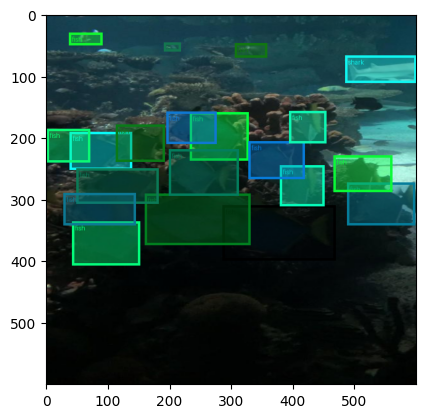

In [38]:
sample = train_dataset[50]
img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)

print ( img_int.shape )

print ( img_int.type() )

plt.imshow(draw_bounding_boxes(
    img_int, 
    sample[1]['boxes'], 
    [classes[i] for i in sample[1]['labels']], 
    width=4, fill=True)
    .permute(1, 2, 0)
)

In [39]:
#pretrained model loading
model = models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)

In [40]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [41]:
import torch.utils.data

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0, collate_fn = collate_fn)   

In [42]:
images, targets = next(iter(train_loader))

In [46]:
#check targets and images
print('Targets:', targets[0])
print('images', images[0])

Targets: {'boxes': tensor([[256.6406, 191.4062, 338.0859, 365.6250],
        [369.7266, 427.3438, 423.6328, 484.3750],
        [ 21.6797, 442.1875,  42.1875, 464.8437],
        [261.9141, 383.5938, 268.3594, 403.9062],
        [330.4688, 491.4062, 339.8438, 500.0000],
        [322.2656, 428.9062, 333.3984, 435.1562]]), 'labels': tensor([7, 5, 1, 1, 1, 1]), 'image_id': tensor([217, 217, 217, 217, 217, 217]), 'area': tensor([14189.3008,  3074.3425,   464.6295,   130.9202,    80.5661,    69.5801]), 'iscrowd': tensor([0, 0, 0, 0, 0, 0])}
images tensor([[[0.0157, 0.0118, 0.0118,  ..., 0.3647, 0.3843, 0.3725],
         [0.0196, 0.0157, 0.0157,  ..., 0.3765, 0.3804, 0.3843],
         [0.0118, 0.0078, 0.0078,  ..., 0.3725, 0.3647, 0.3922],
         ...,
         [0.3373, 0.3020, 0.2824,  ..., 0.0941, 0.0941, 0.0980],
         [0.2471, 0.1686, 0.2431,  ..., 0.0431, 0.0353, 0.0275],
         [0.2392, 0.2196, 0.2235,  ..., 0.0510, 0.0353, 0.0078]],

        [[0.0157, 0.0118, 0.0118,  ..., 0.3529,

In [47]:
images = list(image for image in images)
targets = [{k:v  for k, v in t.items()} for t in targets]
output = model(images, targets)

In [48]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block):

In [53]:
params = [p for p in model.parameters() if p.requires_grad]
#criterion = nn.CrossEntropyLoss() -- define later
optimizer = torch.optim.SGD(params, lr=0.03, momentum = 0.9, nesterov = True, weight_decay=1e-4)
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[16, 22], gamma=0.1)

In [54]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('./logs/small-1')

In [55]:
#lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[16, 22], gamma=0.1)

In [56]:
import sys

def train_one_epoch(model, optimizer, loader, device, epoch):
    model.to(device)
    model.train()

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1.0 / 1000
        warmup_iters = min(1000, len(loader) - 1)
        lr_scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=warmup_factor, total_iters=warmup_iters)
    
    all_losses = []
    all_losses_dict = []

    for images, targets in tqdm(loader):
        images = list(image.to(device) for image in images)

        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        loss_value = losses.item()
        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)

        if not math.isfinite(loss_value):
            print(f'Loss is {loss_value}, stopping training...')
            print(loss_dict)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        writer.add_scalar('./logs/small-1', loss_value)

        if lr_scheduler is not None:
            lr_scheduler.step()

    all_losses_dict = pd.DataFrame(all_losses_dict)

In [57]:
num_epochs = 10

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch)
    lr_scheduler.step()

100%|██████████| 112/112 [10:57<00:00,  5.87s/it]


Evaluation Step

In [65]:
checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
}

torch.save(model.state_dict(), './models/RCNN_model.pth')

#torch.load('./models/RCNN_model.pth')
model.load_state_dict(torch.load('./models/RCNN_model.pth'))

print(torch.__cached__)
torch.cuda.empty_cache()

model.eval()

C:\Users\X\AppData\Roaming\Python\Python311\site-packages\torch\__pycache__\__init__.cpython-311.pyc


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block):

In [70]:
img, _ = test_dataset[20] # or test_dataset without position idk
img_int = torch.tensor(img * 255, dtype=torch.uint8)
with torch.no_grad():
    prediction = model([img.to(device)])
    pred = prediction[0]

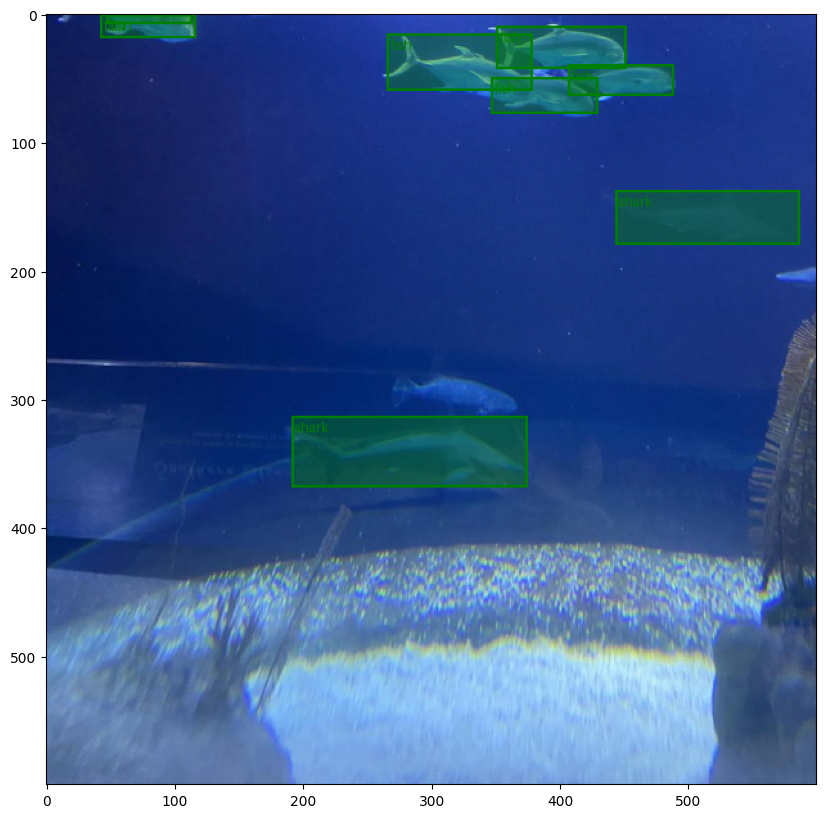

In [71]:
fig = plt.figure(figsize = (14, 10))
plt.imshow(draw_bounding_boxes(img_int,
    pred['boxes'][pred['scores'] > 0.7],
    [classes[i] for i in pred['labels'][pred['scores'] > 0.7].tolist()],
    fill=True,
    width=2,
    colors='green'
    ).permute(1, 2, 0))

In [72]:
print(type(train_dataset))
print(type(model))

<class '__main__.AquariumDetection'>
<class 'torchvision.models.detection.faster_rcnn.FasterRCNN'>


In [ ]:
batch_test = next(iter(train_loader))
images_test, _ = batch_test

print(type(images_test))

background = images_test[:100]
test_images = images_test[100:103]

print(type(background))
print(type(test_images))
print(type(model))

background = np.asarray(background)
background = torch.from_numpy(background)

test_images = np.asarray(test_images)
test_images = torch.from_numpy(test_images)

print(type(background))
print(type(test_images))



<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'torchvision.models.detection.faster_rcnn.FasterRCNN'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'type'>


In [ ]:
#check for effect of leyers
#there a lsit somewhere but I couldn't find it after 5 hours so gg this time
e = shap.DeepExplainer(model=model, data=background)

shap_values = e.shap_values(test_images)

AttributeError: 'list' object has no attribute 'device'

In [107]:
#logs from tensorboard
#run this crap with command tensorboard --logdir=logs

writer.close()

In [114]:
example_input = (torch.randn(1, 1, 600, 600),)
onnx_file = torch.onnx.export(model, example_input, dynamo=False)
onnx_file.optimize()
onnx_file.save( './models/RCNN_detector.onnx')

#visualize it later woth netron app

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Program Files\Python311\Lib\inspect.py", line 1114, in findsource
    line = lines[lnum]
           ~~~~~^^^^^^
IndexError: list index out of range

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\X\AppData\Roaming\Python\Python311\site-packages\torch\_sources.py", line 24, in get_source_lines_and_file
    except OSError as e:
                         
  File "c:\Program Files\Python311\Lib\inspect.py", line 1244, in getsourcelines
    lines, lnum = findsource(object)
                  ^^^^^^^^^^^^^^^^^^
  File "c:\Program Files\Python311\Lib\inspect.py", line 1116, in findsource
    raise OSError('lineno is out of bounds')
OSError: lineno is out of bounds

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "C:\Users\X\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3526

In [ ]:
import netron
import os.path

if os.path.isfile('./models/RCNN_detector.onnx'):
    netron.start('./models/RCNN_detector.onnx')
    
#works for .pth
elif os.path.isfile('./models/RCNN_model.pth'):
    netron.start('./models/RCNN_model.pth')

Serving './models/RCNN_model.pth' at http://localhost:8080
